<a href="https://colab.research.google.com/github/baussel/Satellite_Detection/blob/main/Analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of Results



---


*Ben Aussel, December 2021, ESA*


---



## Google Drive & Modules

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Modules
from PIL import Image
import PIL
import os
import numpy as np
import pandas as pd
from collections import Counter
import glob
import json
from shutil import copyfile
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Analysis

### Import of Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ESA/Results/processed/new/HST_observations_satellites_raw.csv")
data_ACS = data[data["instrument_name"]=="ACS/WFC"]
data_WFC3 = data[data["instrument_name"]=="WFC3/UVIS"]

In [ ]:
data_sats_ACS = data_ACS[data_ACS["flag"]=="satellite"]
data_sats_WFC3 = data_WFC3[data_WFC3["flag"]=="satellite"]

### Fraction

In [ ]:
def fraction(number_images,number_sats):
    """
        Calculates fraction and uncertainty for given number of images and number of images with satellites.
        Prints the values if the set is only viewed in one time interval (no array).
    """
    u_number_sats = np.sqrt(number_sats + 0.0049*number_sats**2)
    frac = number_sats/number_images
    u_frac = u_number_sats/number_images 
    try:
        print("-- Total number of images with satellites: {:.0f} +- {:.0f}".format(number_sats,u_number_sats))
        print("-- Total number of images: {:.0f}".format(number_images))
        print("-- Fraction of images with satellite trails for ACS: ({:.2f} +- {:.2f})%".format(frac*100,u_frac*100))
    except:
        pass
    return frac, u_frac

In [ ]:
print("ACS:")
frac_ACS, u_frac_ACS = fraction(len(data_ACS),len(data_sats_ACS))
print("WFC3/UVIS:")
frac_WFC3, u_frac_WFC3 = fraction(len(data_WFC3),len(data_sats_WFC3))

ACS:
-- Total number of images with satellites: 2418 +- 176
-- Total number of images: 76056
-- Fraction of images with satellite trails for ACS: (3.18 +- 0.23)%
WFC3/UVIS:
-- Total number of images with satellites: 655 +- 53
-- Total number of images: 38551
-- Fraction of images with satellite trails for ACS: (1.70 +- 0.14)%


In [ ]:
def histogram(data):
    return np.histogram(data["start_time_mjd"],bins=bins_mjd)[0]

#Definition of the time intervals
bins_mjd = [52275,52640,53005,53371,53736,54101,54466,54832,55197,55562,55927,56293,56658,57023,57388,57754,58119,58484,58849,59215,59580]
years = [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

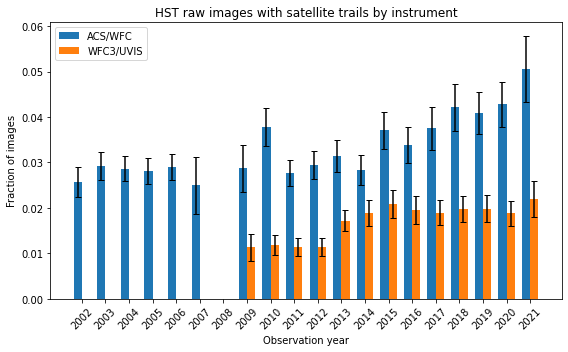

In [ ]:
frac_yrs_ACS, u_frac_yrs_ACS = fraction(histogram(data_ACS),histogram(data_sats_ACS))
frac_yrs_WFC3, u_frac_yrs_WFC3 = fraction(histogram(data_WFC3),histogram(data_sats_WFC3))

plt.figure(figsize=(8,5))
width = 0.35
capsize = 3
plt.bar(np.array(years)-width/2,frac_yrs_ACS, width=width, yerr=u_frac_yrs_ACS,capsize=capsize,label="ACS/WFC")
plt.bar(np.array(years)+width/2,frac_yrs_WFC3, width=width, yerr=u_frac_yrs_WFC3,capsize=capsize,label="WFC3/UVIS")
plt.xticks(years,rotation=45)
plt.xlabel("Observation year")
plt.ylabel("Fraction of images")
plt.title("HST raw images with satellite trails by instrument")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ESA/Results/processed/new/plots/fraction_years.pdf",dpi=100, bbox_inches='tight')

#### Filter


In [ ]:
def hist_filters(data,filters,filters_instrument):
    """
        Counts the number of images for the different filters given by the array. Returns an array containing the corresponding numbers.
    """
    numbers = np.zeros(len(filters))
    for i in range(data.index[-1]):
        try:
            value = data["instrument_configuration"][i].split("|")[6].split("=")[1].replace(";","").replace("CLEAR1L","").replace("CLEAR2L","")\
            .replace("POL0V","").replace("POL120V","").replace("POL60V","").replace("POL0UV","").replace("POL60UV","").replace("POL120UV","")
            if value == "":
                continue
            elif value in filters_instrument:
                for j in range(len(filters)):
                    if value == filters[j]:
                        numbers[j] = numbers[j] + 1
        except:
            continue
    return numbers

In [ ]:
filter_names = ["F225W","F275W","F336W","F350LP","F435W","F475W","F555W","F606W","F658N","F775W","F814W","F850LP"]
filter_names_ACS = ["F435W","F475W","F555W","F606W","F658N","F775W","F814W","F850LP"]
filter_names_WFC3 = ["F225W","F275W","F336W","F350LP","F475W","F555W","F606W","F814W"]

#ACS
filters_ACS = hist_filters(data_ACS,filter_names,filter_names_ACS)
filters_sats_ACS = hist_filters(data_sats_ACS,filter_names,filter_names_ACS)
frac_filters_ACS, u_frac_filters_ACS = fraction(filters_ACS,filters_sats_ACS)

#WFC3
filters_WFC3 = hist_filters(data_WFC3,filter_names,filter_names_WFC3)
filters_sats_WFC3 = hist_filters(data_sats_WFC3,filter_names,filter_names_WFC3)
frac_filters_WFC3, u_frac_filters_WFC3 = fraction(filters_WFC3,filters_sats_WFC3)

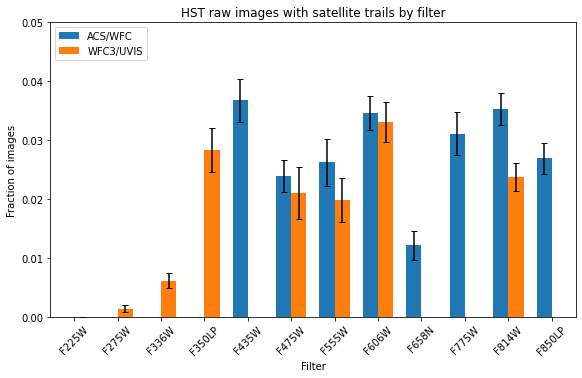

In [ ]:
#Plot
plt.figure(figsize=(8,5))
width = 0.35
capsize = 3
x = np.arange(len(filter_names))
plt.bar(x-width/2,frac_filters_ACS, width=width, yerr=u_frac_filters_ACS,capsize=capsize,label="ACS/WFC")
plt.bar(x+width/2,frac_filters_WFC3, width=width, yerr=u_frac_filters_WFC3,capsize=capsize,label="WFC3/UVIS")
plt.xticks(x,filter_names,rotation=45)
plt.ylim(0,0.05)
plt.tight_layout()
plt.legend(loc="upper left")
plt.xlabel("Filter")
plt.ylabel("Fraction of images")
plt.title("HST raw images with satellite trails by filter")
plt.savefig("/content/drive/MyDrive/ESA/Results/processed/new/plots/filter.pdf",dpi=100, bbox_inches='tight')

#### Normalization

In [ ]:
#Full FOV sizes in degrees
fov_size_ACS = 202/3600 #202x202"
fov_size_WFC3 = 160/3600 #160x160"
#Using only broadband filterswith (lambda > 400nm)
used_filters = ["F435W","F438W","F475W","F555W","F600LP","F606W","F625W","F775W","F814W","F850LP"]

def normalize_and_chance(data,data_sats,fov_value,fov_size,bins_mjd):
    """
        Normalizes the fractions. Divides the number of images with satellites by the total exposure time
        and the fov size. Only images using the full FOV and broadband filters with lambda > 400nm are
        considered. Return also the chance of seeing a satellite for a typical image with full FOV and
        the mean exposure time of the instrument.
    """

    #Number of images with satellites
    hist_sats_norm = np.histogram(data_sats[data_sats["fov_size"]>fov_value][data_sats["instrument_configuration"]\
                            .str.contains('|'.join(used_filters))]["start_time_mjd"],bins=bins_mjd,\
                            weights=data_sats[data_sats["fov_size"]>fov_value][data_sats["instrument_configuration"]\
                            .str.contains('|'.join(used_filters))]["no_sats"])

    #Total exposure time
    hist_exp = np.histogram(data[data["fov_size"]>fov_value][data["instrument_configuration"].str.contains('|'.join(used_filters))]\
                            ["start_time_mjd"],bins=bins_mjd,weights=data[data["fov_size"]>fov_value][data["instrument_configuration"]\
                            .str.contains('|'.join(used_filters))]["exposure_duration"])

    #Total exposure time * fov_size / number of sats
    exp_time_sats = (hist_exp[0]*fov_size)/hist_sats_norm[0]
    u_exp_time_sats = (hist_exp[0]*fov_size*np.sqrt(hist_sats_norm[0] + 0.0049*hist_sats_norm[0]**2))/hist_sats_norm[0]**2

    #Mean exposure time per image
    total_number_of_images = np.histogram(data[data["fov_size"]>fov_value][data["instrument_configuration"].str.contains('|'.join(used_filters))]\
                            ["start_time_mjd"],bins=bins_mjd)
    mean_exp_time = hist_exp[0] / total_number_of_images[0]

    #Divide by total exposure time
    trails_per_second = hist_sats_norm[0]/(hist_exp[0]*fov_size)
    u_trails_per_second = np.sqrt(hist_sats_norm[0]+0.0049*hist_sats_norm[0]**2)/(hist_exp[0]*fov_size)

    #Calculate mean exposure time
    exp_time_mean = np.mean(data[data["fov_size"]>fov_value][data["instrument_configuration"].str.contains('|'.join(used_filters))]["exposure_duration"])
    print("-- Mean exposure time: {:.1f}s".format(exp_time_mean))

    #Multiply with mean exposure time
    chance = trails_per_second*exp_time_mean*fov_size
    u_chance = np.sqrt((exp_time_mean*fov_size*u_trails_per_second)**2)

    #Images with multiple trails
    hist_sats_multiple = np.histogram(data_sats[data_sats["fov_size"]>fov_value][data_sats["instrument_configuration"]\
                            .str.contains('|'.join(used_filters))]["start_time_mjd"][data_sats["no_sats"]>=2],bins=bins_mjd)
    
    return exp_time_sats, u_exp_time_sats, chance, u_chance, mean_exp_time, hist_sats_multiple[0]

In [ ]:
print("ACS:")
norm_ACS, u_norm_ACS, chance_ACS, u_chance_ACS, mean_exp_time_ACS, multiple_ACS = normalize_and_chance(data_ACS,data_sats_ACS,0.083,fov_size_ACS,bins_mjd)
print("WFC3:")
norm_WFC3, u_norm_WFC3, chance_WFC3, u_chance_WFC3, mean_exp_time_WFC3, multiple_WFC3 = normalize_and_chance(data_WFC3,data_sats_WFC3,0.066,fov_size_WFC3,bins_mjd)

ACS:
-- Mean exposure time: 673.2s
WFC3:
-- Mean exposure time: 679.9s


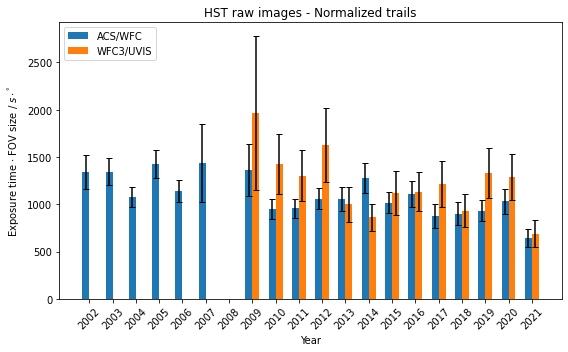

In [ ]:
plt.figure(figsize=(8,5))
width = 0.3
capsize = 3
plt.bar(np.array(years)-width/2,norm_ACS, width=width, yerr=u_norm_ACS,capsize=capsize,label="ACS/WFC")
plt.bar(np.array(years)+width/2,norm_WFC3, width=width, yerr=u_norm_WFC3,capsize=capsize,label="WFC3/UVIS")
plt.xlabel("Year")
plt.ylabel("Exposure time $\cdot$ FOV size / $s\cdot ^°$")
plt.legend(loc="upper left")
plt.title("HST raw images - Normalized trails")
plt.xticks(years,rotation=45)
#plt.xlim(2008.5,2021.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ESA/Results/processed/new/plots/normalized_exp.pdf",dpi=100, bbox_inches='tight')

In [ ]:
bins_2021 = [54832,59215,59580]
print("ACS:")
norm_ACS_2021, u_norm_ACS_2021, chance_ACS_2021, u_chance_ACS_2021, mean_exp_time_ACS_2021, multiple_ACS_2021 = normalize_and_chance(data_ACS,data_sats_ACS,0.083,fov_size_ACS,bins_2021)
print("-- Chance of seeing a satellite 2009-2020: ({:.2f} +- {:.2f})%".format(chance_ACS_2021[0]*100,u_chance_ACS_2021[0]*100))
print("-- Chance of seeing a satellite 2021: ({:.2f} +- {:.2f})%".format(chance_ACS_2021[1]*100,u_chance_ACS_2021[1]*100))
print("--> Increase of {:.0f}%".format(chance_ACS_2021[1]/chance_ACS_2021[0]*100-100))
print("WFC3:")
norm_WFC3_2021, u_norm_WFC3_2021, chance_WFC3_2021, u_chance_WFC3_2021, mean_exp_time_WFC3_2021, multiple_WFC3_2021 = normalize_and_chance(data_WFC3,data_sats_WFC3,0.066,fov_size_WFC3,bins_2021)
print("-- Chance of seeing a satellite 2009-2020: ({:.2f} +- {:.2f})%".format(chance_WFC3_2021[0]*100,u_chance_WFC3_2021[0]*100))
print("-- Chance of seeing a satellite 2021: ({:.2f} +- {:.2f})%".format(chance_WFC3_2021[1]*100,u_chance_WFC3_2021[1]*100))
print("--> Increase of {:.0f}%".format(chance_WFC3_2021[1]/chance_WFC3_2021[0]*100-100))

ACS:
-- Mean exposure time: 673.2s
-- Chance of seeing a satellite 2009-2020: (3.69 +- 0.28)%
-- Chance of seeing a satellite 2021: (5.86 +- 0.87)%
--> Increase of 59%
WFC3:
-- Mean exposure time: 679.9s
-- Chance of seeing a satellite 2009-2020: (2.57 +- 0.23)%
-- Chance of seeing a satellite 2021: (4.39 +- 0.91)%
--> Increase of 71%


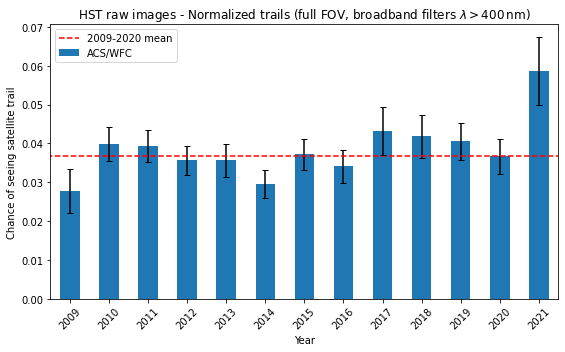

In [ ]:
plt.figure(figsize=(8,5))
width = 0.5
capsize = 3
plt.bar(np.array(years),chance_ACS, width=width, yerr=u_chance_ACS,capsize=capsize,label="ACS/WFC")
#plt.bar(np.array(years)+width/2,chance_WFC3, width=width, yerr=u_chance_ACS,capsize=capsize,label="WFC3/UVIS")
plt.hlines(np.mean(chance_ACS[7:19]),2008,2022,linestyles="--",label="2009-2020 mean",color="red")
plt.xlabel("Year")
plt.ylabel("Chance of seeing satellite trail")
plt.legend(loc="upper left")
plt.title("HST raw images - Normalized trails (full FOV, broadband filters $\lambda > 400\,$nm)")
plt.xticks(years,rotation=45)
plt.xlim(2008.5,2021.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ESA/Results/processed/new/plots/normalized_ACS.pdf",dpi=100, bbox_inches='tight')

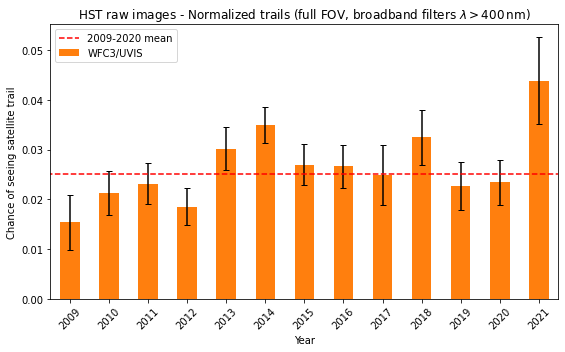

In [ ]:
plt.figure(figsize=(8,5))
width = 0.5
capsize = 3
plt.bar(np.array(years),chance_WFC3, width=width, yerr=u_chance_ACS,capsize=capsize,label="WFC3/UVIS",color="tab:orange")
plt.hlines(np.mean(chance_WFC3[7:19]),2008,2022,linestyles="--",label="2009-2020 mean",color="red")
#plt.hlines(np.mean(chance_WFC3[12]),2009,2021)
plt.xlabel("Year")
plt.ylabel("Chance of seeing satellite trail")
plt.legend(loc="upper left")
plt.title("HST raw images - Normalized trails (full FOV, broadband filters $\lambda > 400\,$nm)")
plt.xticks(years,rotation=45)
plt.xlim(2008.5,2021.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ESA/Results/processed/new/plots/normalized_WFC3.pdf",dpi=100, bbox_inches='tight')

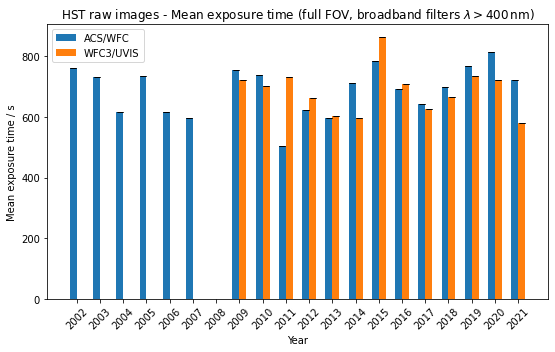

In [ ]:
plt.figure(figsize=(8,5))
width = 0.3
capsize = 3
plt.bar(np.array(years)-width/2,mean_exp_time_ACS, width=width, yerr=0,capsize=capsize,label="ACS/WFC")
plt.bar(np.array(years)+width/2,mean_exp_time_WFC3, width=width, yerr=0,capsize=capsize,label="WFC3/UVIS")
plt.xlabel("Year")
plt.ylabel("Mean exposure time / s")
plt.legend(loc="upper left")
plt.title("HST raw images - Mean exposure time (full FOV, broadband filters $\lambda > 400\,$nm)")
plt.xticks(years,rotation=45)
#plt.xlim(2008.5,2021.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ESA/Results/processed/new/plots/exposure_time.pdf",dpi=100, bbox_inches='tight')

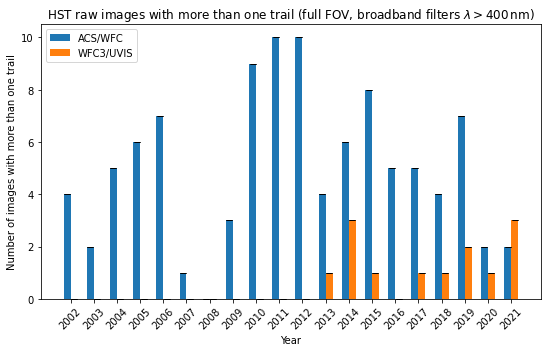

In [ ]:
plt.figure(figsize=(8,5))
width = 0.3
capsize = 3
plt.bar(np.array(years)-width/2,multiple_ACS, width=width, yerr=0,capsize=capsize,label="ACS/WFC")
plt.bar(np.array(years)+width/2,multiple_WFC3, width=width, yerr=0,capsize=capsize,label="WFC3/UVIS")
plt.xlabel("Year")
plt.ylabel("Number of images with more than one trail")
plt.legend(loc="upper left")
plt.title("HST raw images with more than one trail (full FOV, broadband filters $\lambda > 400\,$nm)")
plt.xticks(years,rotation=45)
#plt.xlim(2008.5,2021.5)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ESA/Results/processed/new/plots/multiple.pdf",dpi=100, bbox_inches='tight')